In [105]:
import numpy as np
import pandas as pd
import numpy.random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
numpy.random.seed(1239)

In [2]:
# Read the data
raw_data = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [10]:
#Check if any is nan. 
raw_data.isna().sum().sum()

0

In [30]:
def prepare_data(raw_data):
    labels = raw_data.Attrition == 'Yes'
    employee_data = raw_data.set_index('EmployeeNumber').drop(columns=['Attrition', 'EmployeeCount', 'Over18'])
    employee_data.loc[:, 'OverTime'] = employee_data.OverTime == 'Yes'
    employee_data = pd.get_dummies(employee_data)
    return employee_data, labels


In [35]:
employee_data, labels = prepare_data(raw_data)


Now we want to generate synthetic labels to test if our models works in a controlled environment. Let's assume, that the probability that a person quits is a constant and does not depend on any features. In this case the likelihood that the person has quit follows a geometric distribution. If our model can correctly find this probability *p* based on a synthetic labels, then we can try this model on real data. 

In [106]:
#pick a p
p = 0.1

In [78]:
def quit_after(years, p):
    return numpy.random.rand(years.shape[0]) < (1-p)**(years-1)*p

In [107]:
synthetic_labels = quit_after(employee_data.YearsAtCompany, p)

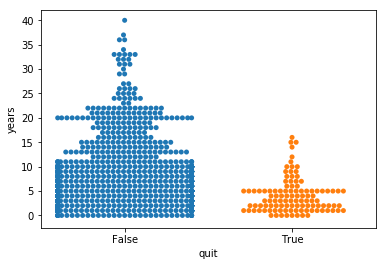

In [108]:
sns.swarmplot(y='years', x='quit', data=pd.DataFrame({"quit":synthetic_labels, 'years':employee_data.YearsAtCompany}))

Based on the chart it seems like a realistic data set.
Now we need to construct our loss function. It will have an additional parameter: number of years

In [110]:
def loss_function(inferred_probability, target_label, years):
    return -target*((years-1)*np.log(1-inferred_probability) - np.ln(inferred_probability)) -
        (1-target)*np.log(1-(1-inferred_probability)**(years-1)*inferred_probability)